<a href="https://colab.research.google.com/github/msr3384/Dataset/blob/main/Wassmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!yes | pip install -U --quiet https://github.com/PythonOT/POT/archive/master.zip
!yes | pip install -U --quiet pyDiffMap
import sklearn

     | 2.8 MB 12.7 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import ot
import ot.plot

In [3]:
import networkx as nx
import time
from sklearn import manifold as man
from sklearn.decomposition import PCA
from pydiffmap import diffusion_map as dmp
import numpy.linalg as LA
import matplotlib.pyplot as plt
import scipy.sparse

In [4]:
from torch import HalfStorage
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

In [5]:
## For saving files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%matplotlib inline
params = {'legend.fontsize':'x-large',
          'figure.figsize': (8,8),
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'axes.titlesize':32
          }

In [7]:
plt.rcParams.update(params)
font = {'family':'serif','weight':'normal','size':18}
plt.rc('font',**font)
np.set_printoptions(edgeitems = 30, linewidth = 100000, formatter = dict(float = lambda x: "%.3g" % x))

11490434/11490434 [==============================] - 0s 0us/step


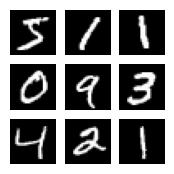

In [8]:
from keras.datasets import mnist
(train_x, train_y),(test_x,test_y) = mnist.load_data()
fig, ax = plt.subplots(3,3,figsize=(2,2))
for i in range(3):
  for j in range(3):
    ax[i,j].imshow(train_x[i+3*j], cmap = plt.get_cmap('gray'))
    ax[i,j].axis('off')

In [9]:
# Functions for voxel reps and pointcloud reps
# NOTE: classical Isomap is defined for voxelized images, not pointclouds.

def vox_to_pointcloud(voxarray,grid,eps=0):
    # Convert a voxel representation ('voxarray') to a (weighted) point cloud representation
    # Assume that the input grid is in "ij meshgrid" format i.e. the grid has two layers, xx and yy, each size (nx)-by-(ny)
    # The voxel array will be unrolled via "column-major" order ("Fortran/Matlab" ordering)
    # Note that initially the number of voxels must equal the number of grid points - but
    # zero voxels will be removed from the representation (i.e. no points with weight zero allowed)
    # if the optional parameter eps is passed, voxels with value less or equal to eps will be dropped
    # The returned array consists of (x,y,w) tuples i.e. X = [x1,y1,w1;x2,y2,w2;...;xP,yP,wP] where P
    # is the number of nonzero points
    xx,yy = np.squeeze(np.split(grid,2))
    X = np.vstack((xx.ravel(),yy.ravel())).T
    nX  = X.shape[0] # Number of points = number of rows
    nvi = voxarray.shape[0] # Number of voxel rows
    nvj = voxarray.shape[1] # Number of voxel cols
    if nX != nvi*nvj: raise ValueError("Number of grid points must equal number of voxels!")
    X = np.concatenate((X,voxarray.T.reshape(nvi*nvj,1)),axis=1)
    return X[X[:,2]>eps,:]

def pointcloud_to_vox(array,grid):
    # Converts a pointcloud representation to a voxel representation
    # Assumes that the grid is in "ij meshgrid" format i.e. grid has two layers, xx and yy; each are size (nx+1)-by-(ny+1)
    # The grid points are assumed to define the corners of the voxels, so the
    # voxel rep will be a single nx-by-ny array with entries equal to the average pointcloud weights
    # V_ij = \mean_k W_k if (x_k,y_k) is in voxel ij
    xx,yy = np.squeeze(np.split(grid,2))

    points = array[:,0:2]
    values = array[:,2]
#   interp = NearestNDInterpolator(points,values)
    interp = LinearNDInterpolator(points,values,fill_value=0.0)
    X = interp(xx,yy).T
    #interp = RBFInterpolator(points,values,smoothing=0,kernel='linear')
    #X = np.reshape(interp(np.vstack((xx.ravel(),yy.ravel())).T),(xx.shape[0],xx.shape[1]))
    return X

In [10]:
# Testing voxel-to-pointcloud conversion

# First, create voxel array
numx = 3
numy = 4

voxarray = np.random.rand(numy,numx)  # Note: number of rows = number of y points
# Set one of the elements to zero (to check zero weight handling)
voxarray[1,2] = 0

# Create a pointcloud grid for vox-to-PC conversion
nxg = numx
nyg = numy
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

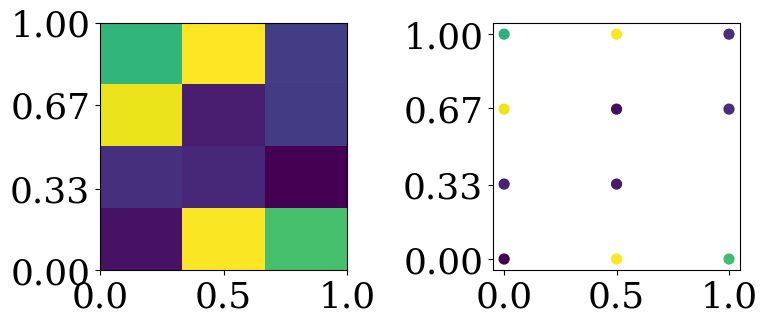

In [11]:
# Convert voxel array to pointcloud
X = vox_to_pointcloud(voxarray,grid)
fig1,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(voxarray,origin='lower',extent=(0,1,0,1))
ax1.set_xticks(np.round(x,2))
ax1.set_yticks(np.round(y,2))
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
ax2.set_xticks(np.round(x,2))
ax2.set_yticks(np.round(y,2))
fig1.tight_layout()

(0.0, 1.0)

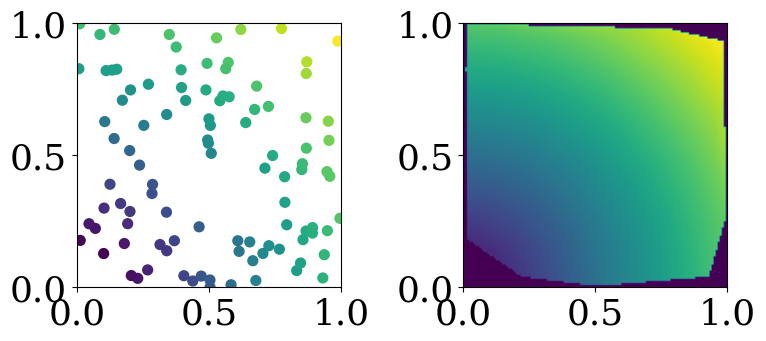

In [12]:
# Testing pointcloud-to-voxel conversion

# Generate a pointcloud by selecting random points
nPC = 100
points = np.random.rand(nPC,2)
values = np.hypot(points[:,0],points[:,1])
PCarray = np.hstack((points,values[:,np.newaxis]))
# Create a grid for pointcloud-to-voxel conversion
nxg = 129
nyg = 129
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
Y = pointcloud_to_vox(PCarray,grid)

fig2,(ax3,ax4) = plt.subplots(1,2)
fig2.tight_layout()
ax3.scatter(PCarray[:,0],PCarray[:,1],s=50,c=PCarray[:,2])
ax4.imshow(Y,origin='lower',extent=[0,1,0,1])
ax3.set_aspect(1)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)

In [13]:
def generate_rectangle(side0, side1, initial_point=[0,0], samples=10):
    # Generates a rectangle in point cloud format
    x = np.linspace(initial_point[0], initial_point[0]+side0, num=samples)
    y = np.linspace(initial_point[1], initial_point[1]+side1, num=samples)
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

def in_triangle(endpoint1,endpoint2,endpoint3,point):
    # Indicator function of a triangle
    # Returns 1 (True) if point is in the triangle, zero (False) else
    c1 = (endpoint2[0]-endpoint1[0])*(point[1]-endpoint1[1]) - (endpoint2[1]-endpoint1[1])*(point[0]-endpoint1[0])
    c2 = (endpoint3[0]-endpoint2[0])*(point[1]-endpoint2[1]) - (endpoint3[1]-endpoint2[1])*(point[0]-endpoint2[0])
    c3 = (endpoint1[0]-endpoint3[0])*(point[1]-endpoint3[1]) - (endpoint1[1]-endpoint3[1])*(point[0]-endpoint3[0])

    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        return True
    else:
        return False

def generate_triangle(endpoint1, endpoint2, endpoint3, samples=100):
    # Generates a triangle in point cloud format
    x = np.linspace(min(endpoint1[0],endpoint2[0],endpoint3[0]), max(endpoint1[0],endpoint2[0],endpoint3[0]), num=samples)
    y = np.linspace(min(endpoint1[1],endpoint2[1],endpoint3[1]), max(endpoint1[1],endpoint2[1],endpoint3[1]), num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_triangle(endpoint1,endpoint2,endpoint3,point):
            xy.append(point)
    return np.array(xy)

def in_circle(center, radius, point):
    if (point[1]-center[1])**2+(point[0]-center[0])**2<=radius**2:
        return True
    else:
        return False

def generate_circle(center, radius, samples=100):
    x = np.linspace(center[0]-radius, center[0]+radius, num=samples)
    y = np.linspace(center[1]-radius, center[1]+radius, num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_circle(center,radius,point):
            xy.append(point)
    return np.array(xy)

def generate_ellipse(center, axis_x, axis_y,samples = 100):
    circle = generate_circle([0,0],1,samples)
    ellipse = dilation(circle,[axis_x, axis_y])
    ellipse = translation(ellipse,center)
    return np.array(ellipse)

In [14]:
def rotation(object, radian_degree):
    A = [[math.cos(radian_degree), -math.sin(radian_degree)],[math.sin(radian_degree), math.cos(radian_degree)]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)
def translation(object, translate_direction):
    object_array = np.array(object)
    direction_array = np.array(translate_direction)
    image = [x + direction_array for x in object_array]
    return np.array(image)

def dilation(object, parameter):
    A = [[parameter[0], 0],[0, parameter[1]]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)

# def diffeo(object, diff_fun):
#     object_array = np.array(object)
#     image = [diff_fun(x) for x in object_array]
#     return np.array(image)

def diffeo(object, a,b):
    object_array = np.array(object)
    image = np.array([1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(a*object_array[:,0]), 1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(b*object_array[:,1])]).T
#    image = np.array([np.exp(a*object_array[:,0]), np.reciprocal((1+b*object_array[:,1])**2)]).T
    print(image.shape)
    return np.array(image)

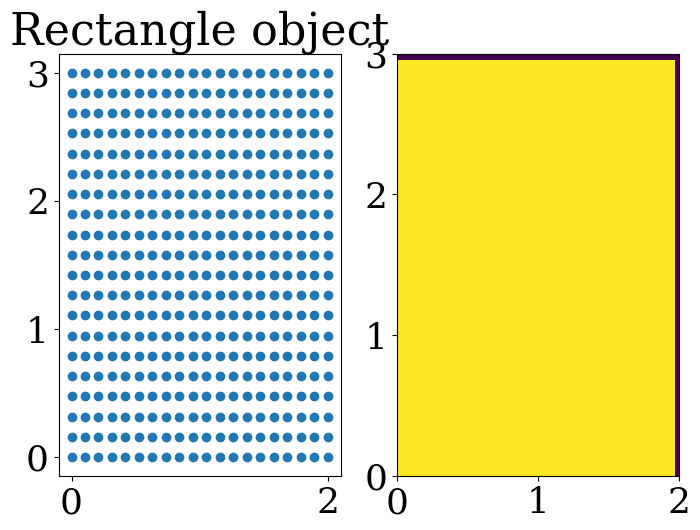

In [21]:
W = 2
H = 3
rect = generate_rectangle(W,H, samples=20)
nxg = 64
nyg = 64
dx = W/nxg
dy = H/nyg

x = np.linspace(0,2+dx,nxg+1)
y = np.linspace(0,3+dy,nyg+1)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
rect_pc    = np.concatenate((rect,np.ones((400,1))),axis=1)
rect_voxel = pointcloud_to_vox(rect_pc,grid)
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(rect[:,0],rect[:,1])
ax1.set_aspect(1)
ax1.set_title('Rectangle object')
ax2.imshow(rect_voxel,origin='lower',extent=[0,2,0,3])
plt.show()

(342, 2)


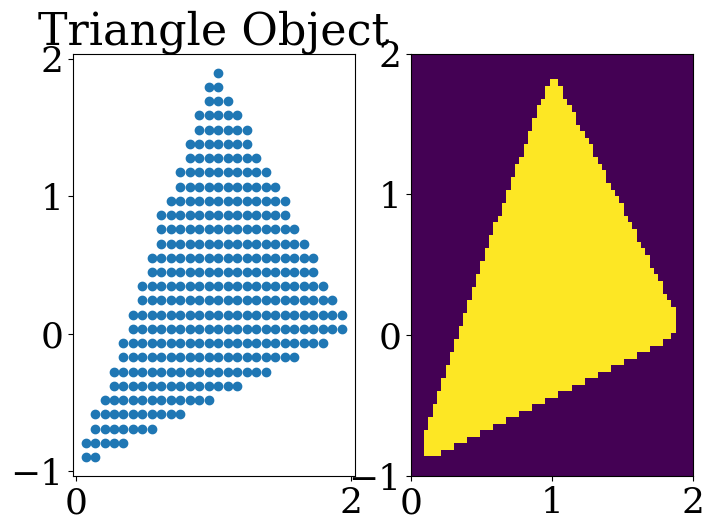

In [23]:
tri = generate_triangle([0,-1],[1,2],[2,0], samples=30)
print(tri.shape)

nxg = 64
nyg = 64
dx = 2/nxg
dy = 3/nyg

x = np.linspace(0,2+dx,nxg+1)
y = np.linspace(-1,2+dy,nyg+1)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
tri_pc    = np.concatenate((tri,np.ones((tri.shape[0],1))),axis=1)
tri_voxel = pointcloud_to_vox(tri_pc,grid)

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(tri[:,0],tri[:,1])
ax1.set_aspect('equal')
ax1.set_title('Triangle Object')
ax2.imshow(tri_voxel,origin='lower',extent=[0,2,-1,2])
plt.show()

Text(0.5, 1.0, 'Disc object')

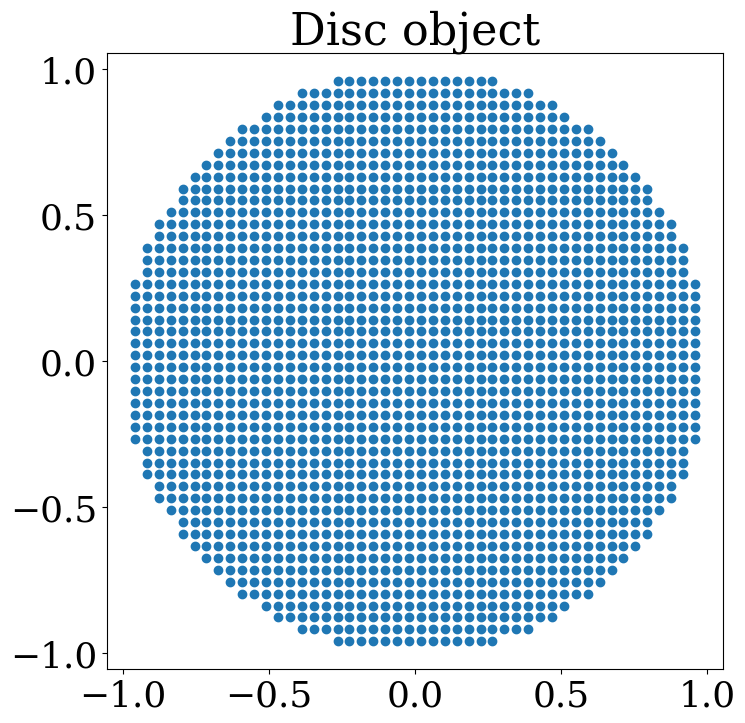

In [35]:
circ = generate_circle([0,0],1,samples=50)

fig,ax = plt.subplots()
ax.scatter(circ[:,0],circ[:,1])
ax.set_aspect('equal')
ax.set_title('Disc object')

(276, 2)


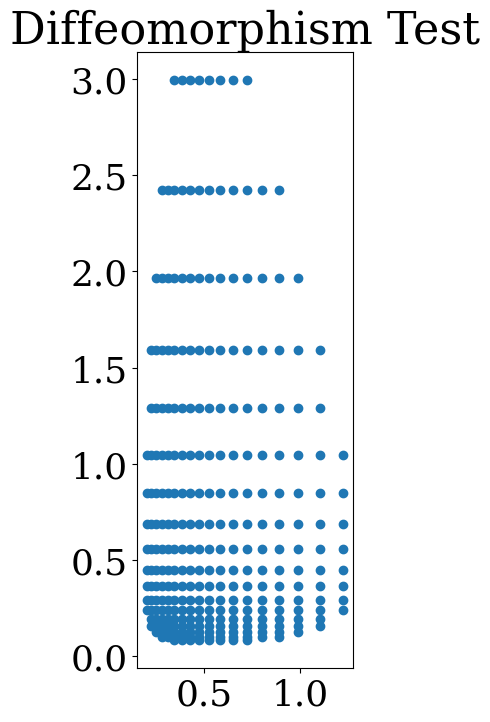

In [37]:
### Test diffeomorphism
circ = generate_circle([0,0],1,samples=20)

#diff_fun = lambda x: np.array([np.exp(-2*x[0]), np.exp(-x[1])])

circ2 = diffeo(circ,-2,-1)
#print(circ2)

fig,ax = plt.subplots()
ax.scatter(circ2[:,0],circ2[:,1])
ax.set_aspect('equal')
ax.set_title('Diffeomorphism Test')
plt.show()

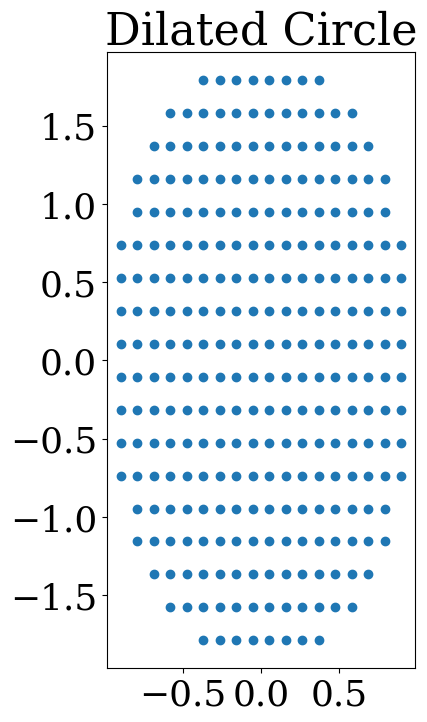

In [52]:
a = dilation(circ,[1,2])

fig, ax = plt.subplots()
ax.scatter(a[:,0],a[:,1])
ax.set_aspect('equal')
ax.set_title('Dilated Circle')
plt.show()

(276, 2)